<div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'>fashionMNIST</div>
<div style='text-align: center'>
    <img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/fashionMNIST.png" width="256">
</div>  

> https://www.larousse.fr/dictionnaires/francais/inf%C3%A9rence/42907<br><br>

>> **inférence** : Opération par laquelle on passe d'une assertion considérée comme vraie à une autre assertion au moyen d'un système de règles qui rend cette deuxième assertion également vraie.<br>

>> **Inférence statistique** : Ensemble des méthodes permettant de formuler en termes probabilistes un jugement sur une population à partir des résultats observés sur un échantillon extrait au hasard de cette population.<br>
 

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation du document</div></b>

In [1]:
import os
# import json
# @param ["tensorflow", "jax", "torch"]
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_XLA_FLAGS']='--tf_xla_auto_jit=1,--tf_xla_always_defer_compilation=true'
# os.environ['XLA_FLAGS']='--xla_backend_optimization_level=0,--xla_gpu_autotune_level=4,--xla_gpu_disable_ptxas_optimizations=true,--xla_gpu_use_cudnn_batchnorm_level=2'
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='5'

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Import libriries </div></b>

In [2]:
import numpy as np, pandas as pd, seaborn as sns, warnings, os, sys, pickle, time
from matplotlib import pyplot as plt
from datetime import datetime as dt

import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.preprocessing import label_binarize
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                            precision_score, recall_score, f1_score, fbeta_score, jaccard_score, \
                            precision_recall_curve, average_precision_score, balanced_accuracy_score, \
                            classification_report,roc_auc_score

tf.get_logger().setLevel('ERROR')# Suppress TensorFlow logging (2)

In [4]:
print("Tensorflow\t : %s\tCUDA %s\tGPU %s\tXLA %s\nKeras\t\t : %s\nPandas\t\t : %s\nNumPy\t\t : %s"%
      (tf.__version__, 
       tf.test.is_built_with_cuda(), 
       tf.test.is_built_with_gpu_support(), 
       tf.test.is_built_with_xla(), 
       tf.keras.__version__, 
       pd.__version__, 
       np.__version__))

Tensorflow	 : 2.17.0	CUDA True	GPU True	XLA True
Keras		 : 3.6.0
Pandas		 : 2.2.2
NumPy		 : 1.26.4


# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation des GPUs presents</div></b>

In [5]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) >  0 :
    for i, gpu in enumerate(physical_devices):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

    strategy = tf.distribute.experimental.CentralStorageStrategy()
    print('Le système est initialisé avec {0:d} GPUs'.format(strategy.num_replicas_in_sync))

Le système est initialisé avec 1 GPUs


I0000 00:00:1751702770.825336   71032 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1751702770.855143   71032 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1751702770.855261   71032 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1751702770.861867   71032 service.cc:146] XLA service 0x3e8e4140 initialized for platfor

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Outils du document</div></b>

In [6]:
palette = [
            "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", "#d1e5f0", "#fddbc7",
            "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#f5054f", "#a0450e",
            "#0339f8", "#f4320c", "#fec615", "#017a79", "#85a3b2", "#fe2f4a", "#a00498", "#b04e0f",
            "#0165fc", "#ff724c", "#fddc5c", "#11875d", "#89a0b0", "#fe828c", "#cb00f5", "#b75203",
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#ffb7ce", "#c071fe", "#ca6b02",
            "#92c5de", "#f4a582", "#fef69e", "#18d17b", "#c5c9c7", "#ffcfdc", "#caa0ff", "#cb7723",
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#d8863b",
            "#030764", "#be0119", "#dbb40c", "#005249", "#3c4142", "#cb0162", "#5d1451", "#653700",
            "#040348", "#67001f", "#b27a01", "#002d04", "#000000", "#a0025c", "#490648", "#3c0008"
          ]

In [7]:
nom_projet                = "04-L'apprentissage et l'inference du modèle-fashionMNIST-Categorical"
repertoireProjet          = os.getcwd()
repertoireEnregistrement  = repertoireProjet +'/'+nom_projet+ '/repertoire.images'
repertoireSauvegardes     = repertoireProjet +'/'+nom_projet+ '/repertoire.sauvegardes'

def controleExistenceRepertoire(directory, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(directory)
    if path_exists:
        if not os.path.isdir(directory):
            raise Exception("Trouvé le nom "+directory+" mais c'est un fichier, pas un répertoire")
            return False
        return True
    if create_if_needed:
        os.makedirs(directory)
        
controleExistenceRepertoire(repertoireEnregistrement)
controleExistenceRepertoire(repertoireSauvegardes)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    plt.savefig(os.path.join(repertoireEnregistrement,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')
    
def sauvegarderModelPoids(model, fichierPoids, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez les poids du modèle Keras."""
    if fichierPoids != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichierPoids))
        model.save_weights(nomFichier)

def sauvegarderModel(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez le modèle Keras."""
    if fichier != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
        model.save(nomFichier)

def lectureModelPoids(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Si le fichier existe, il est chargé et retourne True, sinon retourne False."""
    nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
    if os.path.exists(nomFichier):
        if os.path.isfile(nomFichier):
            model.load_weights(nomFichier)
            return True
    return False

def sauvegardeHistorique(model,
                         repertoireSauvegardes,
                         nomSauvegarde='one_hidden_layer_history_batch_size_1'):

    history = pd.DataFrame( model.history)
    history.reset_index(inplace=True)
    history.rename(columns={'index':'epoch'},inplace=True)
    history.to_parquet(os.path.join(repertoireSauvegardes,f'{nomSauvegarde}.gzip'),compression='gzip', engine='pyarrow') 
    return history

def afficheHistoriqueEntrainement(history, palette):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(48,16));
    markersize = 8
    linewidth=2
    
    graph = sns.lineplot(x='epoch', 
                         y='accuracy',  
                         data=history,
                         ax=ax[0],      
                         label='accuracy',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[0],
                         );
    graph = sns.lineplot(x='epoch', 
                         y='val_accuracy',  
                         data=history,
                         ax=ax[0],      
                         label='val_accuracy',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[1],
                         );
    
    graph = sns.lineplot(x='epoch', 
                         y='loss',  
                         data=history,
                         ax=ax[1],      
                         label='loss',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[0],
                         );
    graph = sns.lineplot(x='epoch', 
                         y='val_loss',  
                         data=history,
                         ax=ax[1],      
                         label='val_loss',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[1],
                         );
    sauvegarderImage('afficheHistoriqueEntrainement')

def afficheMatriceConfusion(observations,predictions,dictLabels):
    plt.figure(figsize=(8,8))
    sns.set(font_scale=1.5)
    sns.heatmap(pd.crosstab(observations,predictions), 
                fmt= '.0f',
                linewidths=0.3,
                #vmax=1.0, 
                square=True, 
                cmap=plt.cm.Blues,
                linecolor='white', 
                annot=True,
                cbar=False,
                xticklabels=dictLabels.values(), 
                yticklabels=dictLabels.values()
               );
    plt.xlabel('Observations', fontsize = 18);
    plt.ylabel('Prédictions', fontsize = 18);
    sauvegarderImage('afficheMatriceConfusion')

def executeApprentissageChoixClassifieurs(model,
                                          X_test,
                                          y_test,
                                          label_dict,
                                          couleurs,
                                          nom_essai = 'initial'
                                         ):
    
    def afficheCourbes(vraisPositifs,fauxPositifs,aucROCt,precisions,sensibilites,avgPrecRec,nbClasses,lw,label_dict):
        plt.figure(figsize=(24, 24));
        for i, color in zip(range(nbClasses), palette):
            plt.plot(fauxPositifs[i], vraisPositifs[i], color=color, lw=lw,
                     label=' ' + label_dict[i] + ' (AUC = {1:0.8f})'
                                                             ''.format(i, aucROCt[i]))
    
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Taux de faux Positifs-(1 - Spécificité) = VN / (FP + VN)',size=18)
        plt.ylabel('Taux de vrais positifs-Sensibilité = VP / (VP + FN)',size=18)
        plt.title('Courbe ROC (Receiver Operating Caracteristic) -- ',size=20)
        plt.legend(loc="lower right"); #, fontsize='large'
        sauvegarderImage('Courbe ROC')
        
        plt.figure(figsize=(24,24));
    
        f_scores = np.linspace(0.2, 0.9, num=8)
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    
        for i, color in zip(range(nbClasses), palette):
            plt.step(sensibilites[i], 
                         precisions[i], 
                         where='post', 
                         color=color, 
                         lw=lw, 
                         label=f"{label_dict[i]}(APR = {avgPrecRec[label_dict[i]]:0.8f})"
                    )
            plt.fill_between(sensibilites[i], precisions[i], step='post', alpha=0.05)            
    
            # plt.plot(fauxPositifs[i], vraisPositifs[i], color=color, lw=lw,
            #          label=' ' + label_dict[i] + ' (AUC = {1:0.8f})'
            #                                                  ''.format(i, aucROCt[i]))        
    
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])        
        plt.xlabel('Sensibilité/Rappel(Recall) = VP / (VP + FN)',size=18)
        plt.ylabel('Précision = VP / (VP + FP)',size=18)        
        plt.title('Courbe Précision-Rappel',size=20)
        plt.legend(loc="lower right") # , fontsize = 'large'
        sauvegarderImage('Courbe Précision-Rappel')
    
    cvF1, cvF1SD, cvAccuracy, cvAccSD, aucROC, avgPrecRec, accuracy, balanced_accuracy, logloss, hammingloss, precision, sensibilite, \
    f1, f2, f05, jaccard, vrais_negatifs, faux_positifs, faux_negatifs, vrais_positifs, total_positifs, aucROCtn = \
        dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(),\
        dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    #
    oneloss, precision_micro, precision_macro, precision_weighted, \
    sensibilite_macro, sensibilite_micro, sensibilite_weighted, \
    f1_micro, f1_macro, f1_weighted,f2_micro,f2_macro,f2_weighted,f05_micro,f05_macro,f05_weighted = \
        dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), \
        dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    
    fauxPositifs, vraisPositifs, precisions, sensibilites, aucROCt, pr_auc, tauxROC, tauxPR = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()        
    
    
    lw = 1
    # couleurs    = sns.hls_palette(len(classifieursDict.keys()), l=.4, s=.9)
    nbClasses   = len(dictLabels.keys())
    listClasses = list(dictLabels.keys())
    
    y_testA  = label_binarize(y_test, classes=listClasses)
    plt.figure(figsize=(18,18))
    
    
    t1 = time.time()  
    classifier = model
    
    # y_score     = model.predict_proba(X_test)
    # y_pred      = model.predict(X_test)
    y_score     = model.predict(X_test)
    y_pred      = np.argmax(y_score, axis=-1) 
    y_predA     = label_binarize(y_pred, classes=listClasses)
    
    accuracy['global']              = accuracy_score(y_test, y_pred)
    balanced_accuracy['global']     = balanced_accuracy_score(y_test, y_pred)
    precision['global']             = precision_score(y_test, y_pred, average='weighted')
    sensibilite['global']           = recall_score(y_test, y_pred, average='weighted')
    
    f1['global']                    = f1_score(y_test, y_pred, average='weighted')
    f2['global']                    = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    f05['global']                   = fbeta_score(y_test, y_pred, beta=0.5, average='weighted')
    
    vrais_negatifs['global']        = 0
    faux_positifs ['global']        = 0
    faux_negatifs ['global']        = 0
    vrais_positifs['global']        = 0
    total_positifs['global']        = 0
    
    
    aucROC['global'] = roc_auc_score(y_test, y_score, multi_class='ovr')
    
    for i in range(nbClasses):
        fauxPositifs[i], vraisPositifs[i], tauxROC[i] = roc_curve(y_testA[:, i], y_score[:, i])
        aucROCt[i]                                    = auc(fauxPositifs[i], vraisPositifs[i])
        precisions[i], sensibilites[i], tauxPR[i]     = precision_recall_curve(y_testA[:, i], y_score[:, i])
    
        aucROC[label_dict[i]]                = aucROCt[i]
        avgPrecRec[label_dict[i]]            = average_precision_score(y_testA[:, i], y_score[:, i])
        accuracy[label_dict[i]]              = accuracy_score(y_testA[:, i], y_predA[:, i])
        balanced_accuracy[label_dict[i]]     = balanced_accuracy_score(y_testA[:, i],y_predA[:, i])
        logloss[label_dict[i]]               = log_loss(y_testA[:, i], y_predA[:, i])
        hammingloss[label_dict[i]]           = hamming_loss(y_testA[:, i], y_predA[:, i])
        precision[label_dict[i]]             = precision_score(y_testA[:, i], y_predA[:, i])
        sensibilite[label_dict[i]]           = recall_score(y_testA[:, i], y_predA[:, i])
        f1[label_dict[i]]                    = f1_score(y_testA[:, i], y_predA[:, i])
        f2[label_dict[i]]                    = fbeta_score(y_testA[:, i], y_predA[:, i], beta=2)
        f05[label_dict[i]]                   = fbeta_score(y_testA[:, i], y_predA[:, i], beta=0.5)
      
        jaccard[label_dict[i]]               = jaccard_score(y_testA[:, i], y_predA[:, i])
        vrais_negatifs[label_dict[i]]        = confusion_matrix(y_testA[:, i], y_predA[:, i])[0, 0]
        faux_positifs[label_dict[i]]         = confusion_matrix(y_testA[:, i], y_predA[:, i])[0, 1]
        faux_negatifs[label_dict[i]]         = confusion_matrix(y_testA[:, i], y_predA[:, i])[1, 0]
        vrais_positifs[label_dict[i]]        = confusion_matrix(y_testA[:, i], y_predA[:, i])[1, 1]
        total_positifs[label_dict[i]]        = vrais_positifs[label_dict[i]] + faux_negatifs [label_dict[i]]
        vrais_negatifs['global']              += vrais_negatifs[label_dict[i]]
        faux_positifs ['global']              += faux_positifs [label_dict[i]]
        faux_negatifs ['global']              += faux_negatifs [label_dict[i]]
        vrais_positifs['global']              += vrais_positifs[label_dict[i]]
    
    
    total_positifs['global'] = vrais_positifs['global'] + faux_negatifs ['global']
    
    
    fauxPositifs["micro"], vraisPositifs["micro"], _ = roc_curve(y_testA.ravel(), y_score.ravel())
    aucROCt["micro"]                                 = auc(fauxPositifs["micro"], vraisPositifs["micro"])
    
    listFauxPositifs = np.unique(np.concatenate([fauxPositifs[i] for i in range(nbClasses)]))
    moyenneVraisPositifs = np.zeros_like(listFauxPositifs)
    for i in range(nbClasses):
        moyenneVraisPositifs += np.interp(listFauxPositifs, fauxPositifs[i], vraisPositifs[i])
    
    moyenneVraisPositifs /= nbClasses
    
    fauxPositifs["macro"], vraisPositifs["macro"] = listFauxPositifs, moyenneVraisPositifs
    aucROCt["macro"] = auc(fauxPositifs["macro"], vraisPositifs["macro"])
    # aucROC['global'] = aucROCt["macro"]  # (aucROCt["micro"],aucROCt["macro"])
    
    avgPrecRec['global'] = average_precision_score(y_testA.ravel(), y_score.ravel(), average='weighted')
    
    afficheCourbes(vraisPositifs,fauxPositifs,aucROCt,precisions,sensibilites,avgPrecRec,nbClasses,lw,label_dict);
    
    print ("Area under the ROC curve : %0.4f" % aucROC['global'],end='\t--\t')
    print('Exécution  :'+('%.2fs' % (time.time() - t1)).lstrip('0'))
        
    resultats = pd.DataFrame(pd.Series(aucROC), columns=["aucROC"])
    resultats["avgPrecRec"]              = pd.Series(avgPrecRec)
    resultats["f1"]                      = pd.Series(f1)
    resultats["f2"]                      = pd.Series(f2)
    resultats["f05"]                     = pd.Series(f05)
    resultats["accuracy"]                = pd.Series(accuracy)
    
    resultats["precision"]               = pd.Series(precision)
    resultats["sensibilite"]             = pd.Series(sensibilite)
    resultats["vrais_positifs"]          = pd.Series(vrais_positifs)
    resultats["vrais_negatifs"]          = pd.Series(vrais_negatifs)
    resultats["faux_positifs"]           = pd.Series(faux_positifs)
    resultats["faux_negatifs"]           = pd.Series(faux_negatifs)
    resultats["total_positifs"]          = pd.Series(total_positifs)
    
    resultats.reset_index(inplace=True)
    resultats.rename(columns={"index": "Classe"}, inplace=True)
    resultats['essai'] = nom_essai
    return resultats

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Lecture des données</div></b>

In [8]:
random_seed = 42
np.random.seed(random_seed)

# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# scale data to range [-0.5, 0.5]
X_train -= 0.5
X_test -= 0.5

# save the original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=number_of_classes)

In [9]:
dictLabels = {0:'T-shirt',
              1:'Pantalon',
              2:'Pull',
              3:'Robe',
              4:'Manteau',
              5:'Sandale',
              6:'Chemise',
              7:'Baskets',
              8:'Sac',
              9:'Bottines'}

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Création et compilation d'un modèle</div></b>

In [10]:
def make_model():
    model = Sequential()
    model.add(Dense(number_of_pixels, 
                    activation='relu',
                    input_shape=[number_of_pixels]))
    model.add(Dense(number_of_classes, 
                    activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

# make the model
model = make_model()

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 784)            │       615,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 623,290 (2.38 MB)

 Trainable params: 623,290 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Entrainement du modèle -Batch Size 256</div></b>

In [12]:
epochs=128
batch_size=256

model_history = model.fit( X_train.reshape((X_train.shape[0], number_of_pixels)), 
                           y_train, 
                           validation_data=(X_test.reshape((X_test.shape[0], number_of_pixels)), y_test), 
                           epochs=epochs, 
                           batch_size=batch_size, 
                           verbose=2)

Epoch 1/128


I0000 00:00:1751702772.869141   71221 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 - 3s - 13ms/step - accuracy: 0.8200 - loss: 0.5035 - val_accuracy: 0.8453 - val_loss: 0.4325
Epoch 2/128
235/235 - 0s - 2ms/step - accuracy: 0.8632 - loss: 0.3759 - val_accuracy: 0.8578 - val_loss: 0.3922
Epoch 3/128
235/235 - 0s - 1ms/step - accuracy: 0.8785 - loss: 0.3364 - val_accuracy: 0.8649 - val_loss: 0.3878
Epoch 4/128
235/235 - 0s - 1ms/step - accuracy: 0.8868 - loss: 0.3105 - val_accuracy: 0.8742 - val_loss: 0.3502
Epoch 5/128
235/235 - 0s - 1ms/step - accuracy: 0.8930 - loss: 0.2912 - val_accuracy: 0.8699 - val_loss: 0.3697
Epoch 6/128
235/235 - 0s - 1ms/step - accuracy: 0.9000 - loss: 0.2708 - val_accuracy: 0.8727 - val_loss: 0.3492
Epoch 7/128
235/235 - 0s - 787us/step - accuracy: 0.9059 - loss: 0.2561 - val_accuracy: 0.8776 - val_loss: 0.3424
Epoch 8/128
235/235 - 0s - 858us/step - accuracy: 0.9106 - loss: 0.2419 - val_accuracy: 0.8854 - val_loss: 0.3221
Epoch 9/128
235/235 - 0s - 1ms/step - accuracy: 0.9147 - loss: 0.2325 - val_accuracy: 0.8809 - val_loss: 0.3383

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Affichage historique de l'apprentissage </div></b>

In [13]:
history = sauvegardeHistorique(model_history,
                               repertoireSauvegardes,
                               nomSauvegarde='one_hidden_layer_history_batch_size_256')

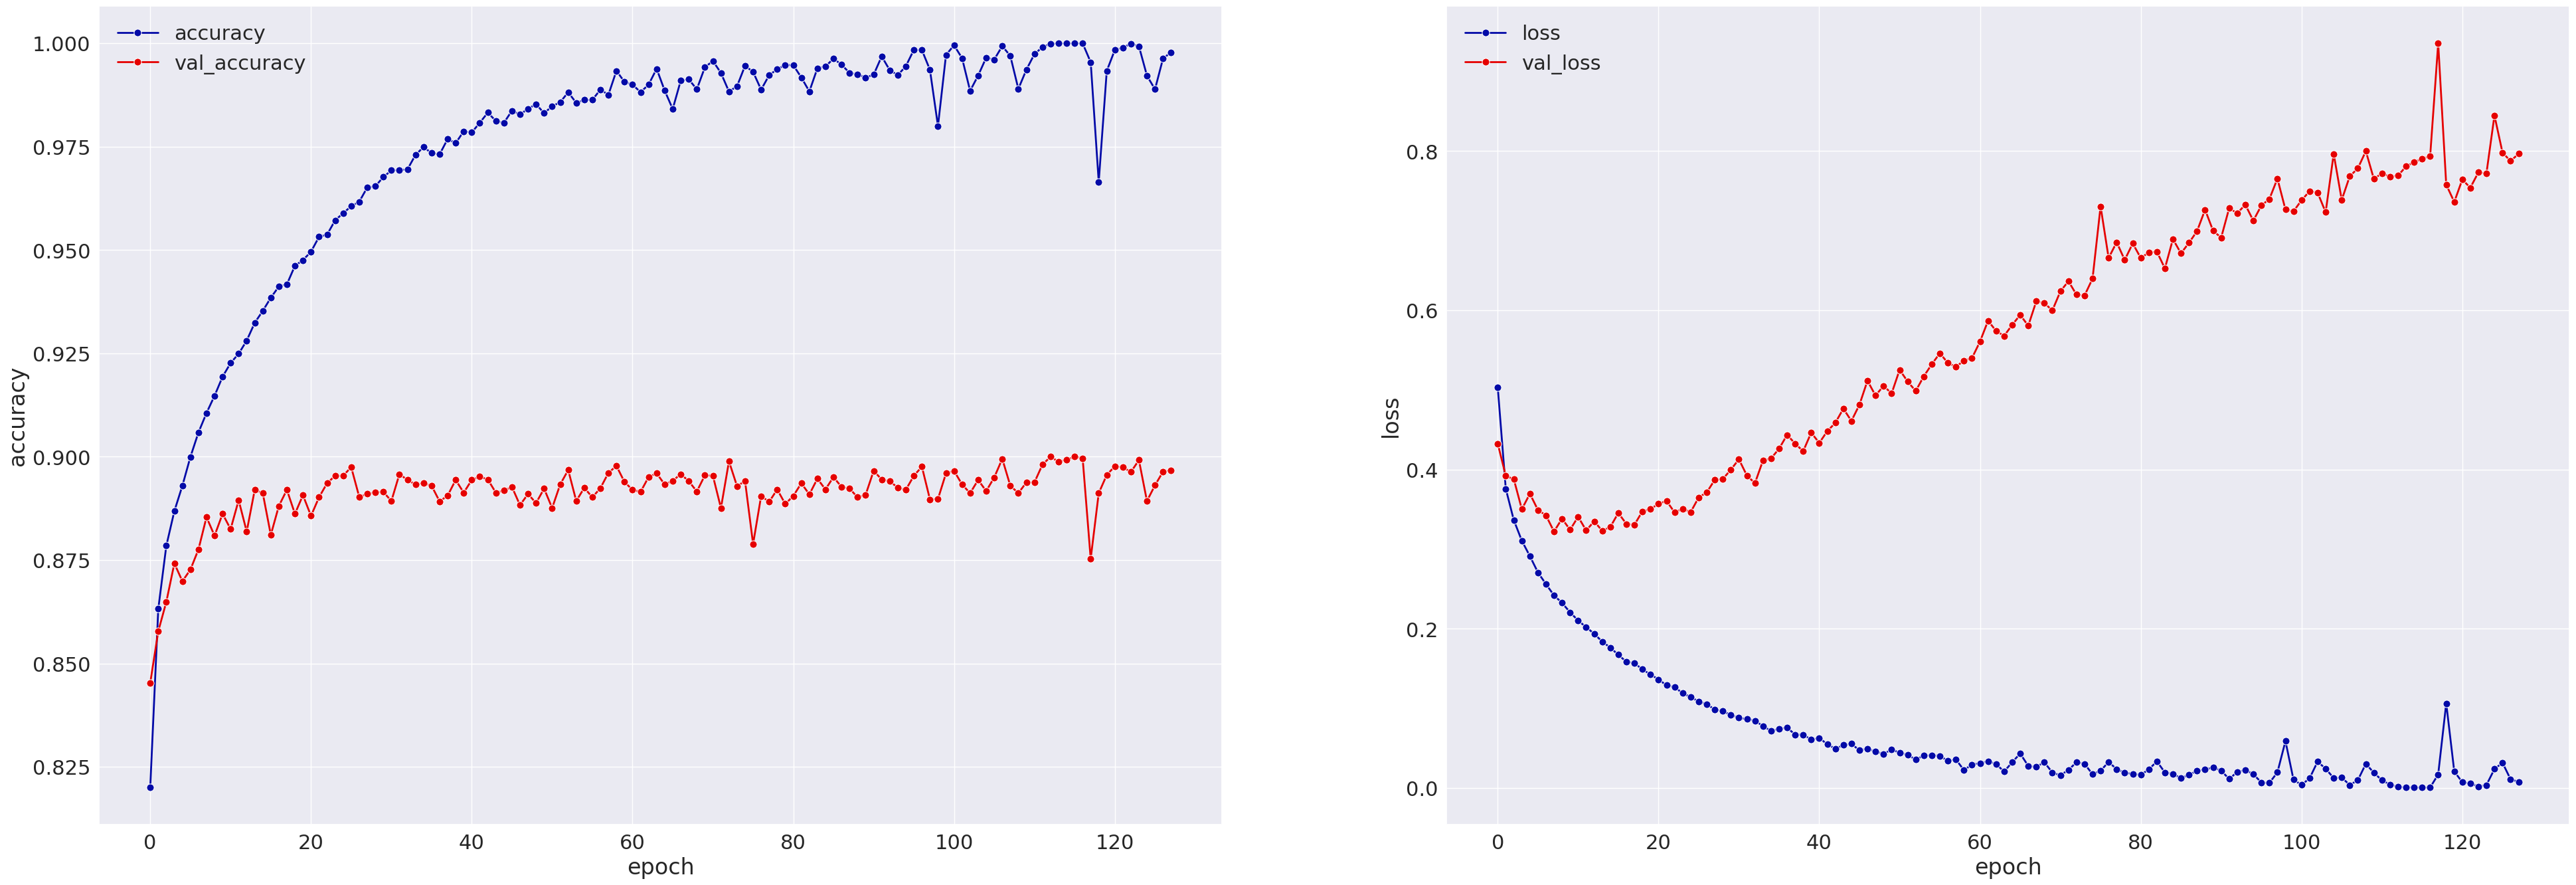

In [14]:
afficheHistoriqueEntrainement(history, palette)

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Sauvegarde du modèle </div></b>

In [15]:
model.save(os.path.join(repertoireSauvegardes,'Keras-03-HistoriqueEntrainement.one_hidden_layer_history_batch_size_256.keras'))

In [16]:
sauvegarderModel(model, 'one_hidden_layer_history_batch_size_256')

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Chargement du modèle </div></b>

In [17]:
model = tf.keras.models.load_model(os.path.join(repertoireSauvegardes,
                                   'Keras-03-HistoriqueEntrainement.one_hidden_layer_history_batch_size_256.keras'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 784)            │       615,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,869,872 (7.13 MB)

 Trainable params: 623,290 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,246,582 (4.76 MB)

In [18]:
model.fit( X_train.reshape((X_train.shape[0], number_of_pixels)), 
           y_train, 
           validation_data=(X_test.reshape((X_test.shape[0], number_of_pixels)), y_test), 
           epochs=2, 
           batch_size=batch_size, 
           verbose=1)

Epoch 1/2
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9985 - loss: 0.0059 - val_accuracy: 0.8896 - val_loss: 0.8789
Epoch 2/2
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.9889 - loss: 0.0318 - val_accuracy: 0.8876 - val_loss: 0.8239


In [19]:
model.history.history

{'accuracy': [0.9974666833877563, 0.9887999892234802],
 'loss': [0.00990891270339489, 0.0321204774081707],
 'val_accuracy': [0.8895999789237976, 0.8876000046730042],
 'val_loss': [0.8788583278656006, 0.8239048719406128]}

In [20]:
h = pd.DataFrame( model.history.history)
h.reset_index(inplace=True)
h.rename(columns={'index':'epoch'},inplace=True)

In [21]:
h.epoch = h.epoch + 20

In [22]:
history = pd.concat([history,h],ignore_index=True)

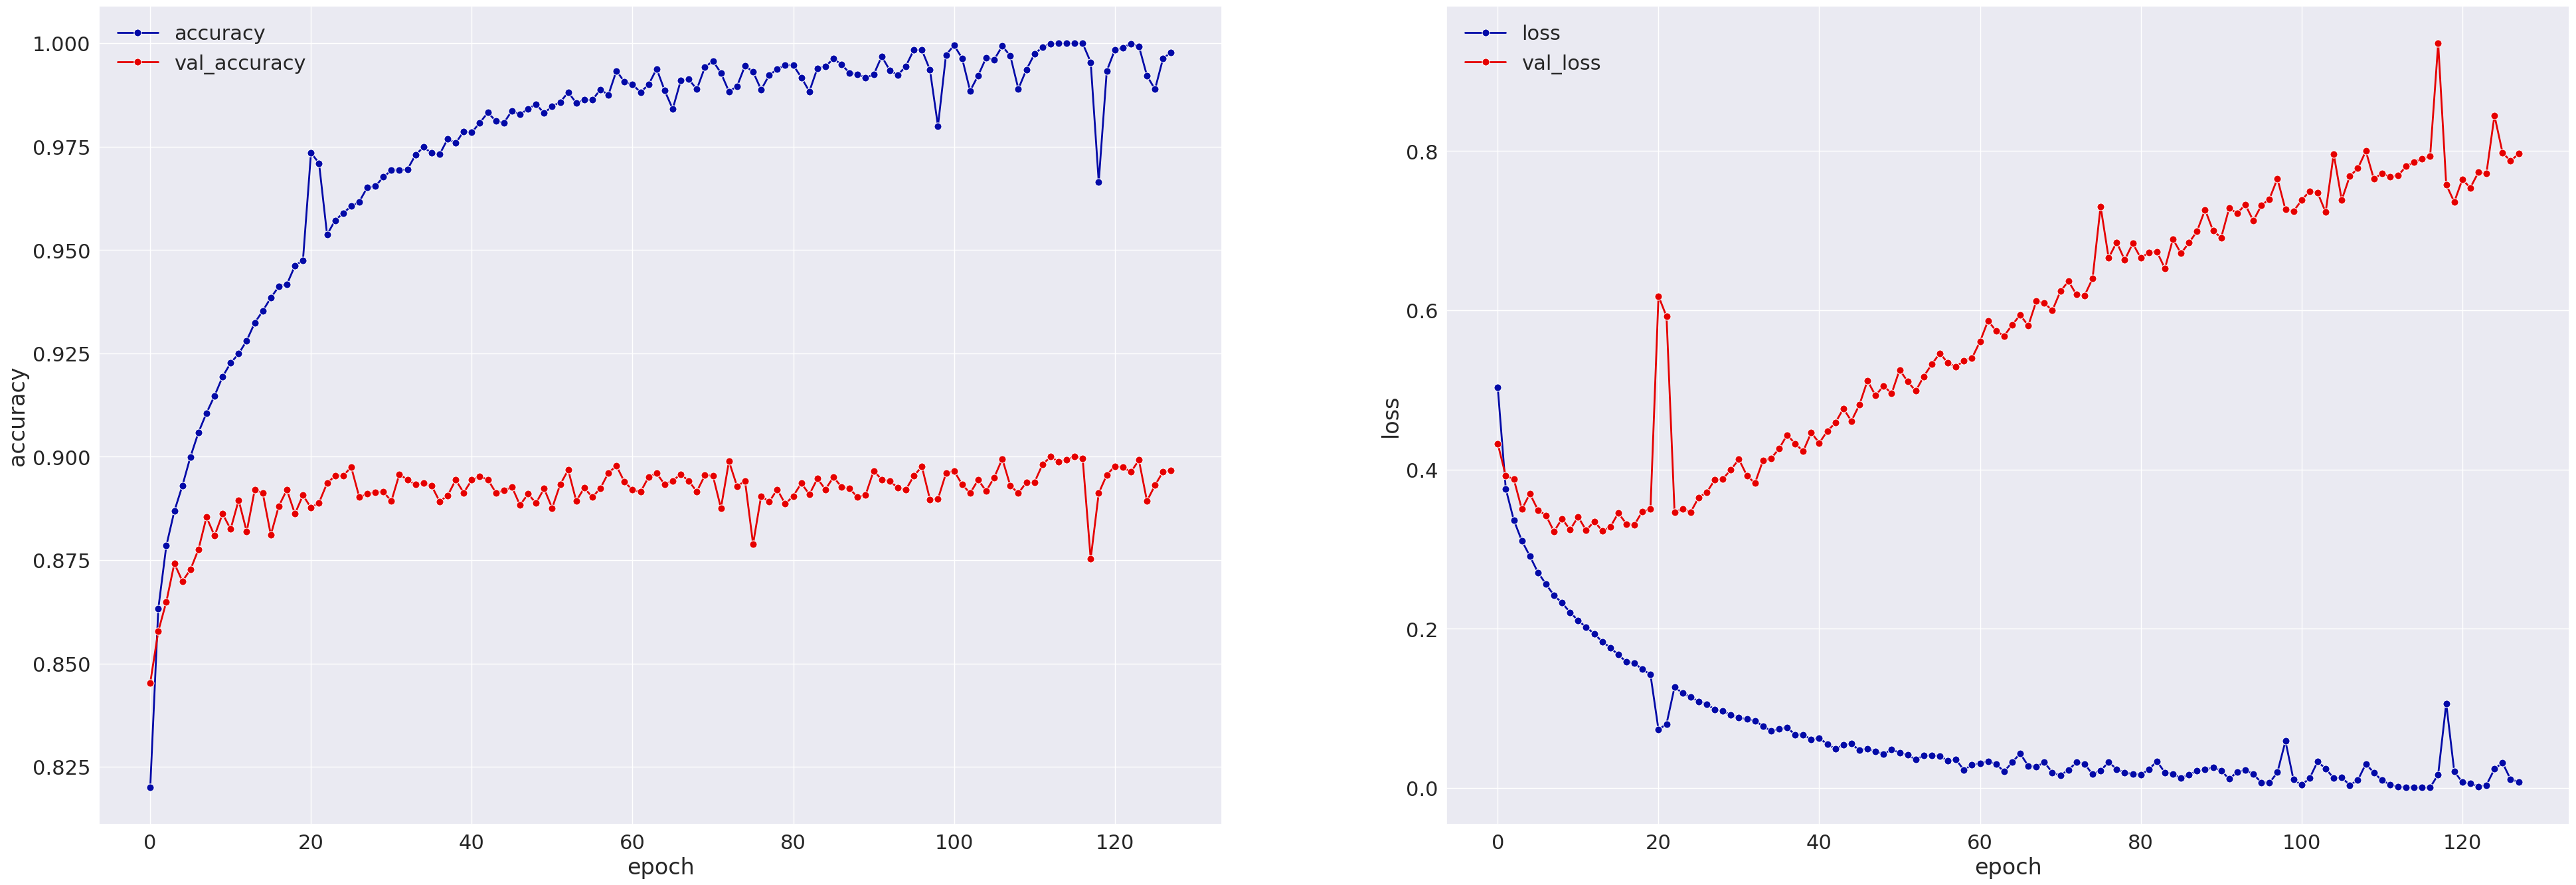

In [23]:
afficheHistoriqueEntrainement(history, palette)

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Inférence</div></b>

In [24]:
probabilities = model.predict(X_test.reshape((X_test.shape[0], number_of_pixels)), verbose=0)
predictions = np.argmax(probabilities, axis=-1)

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Probabilités pour les 4 premiers prédictions </div></b>

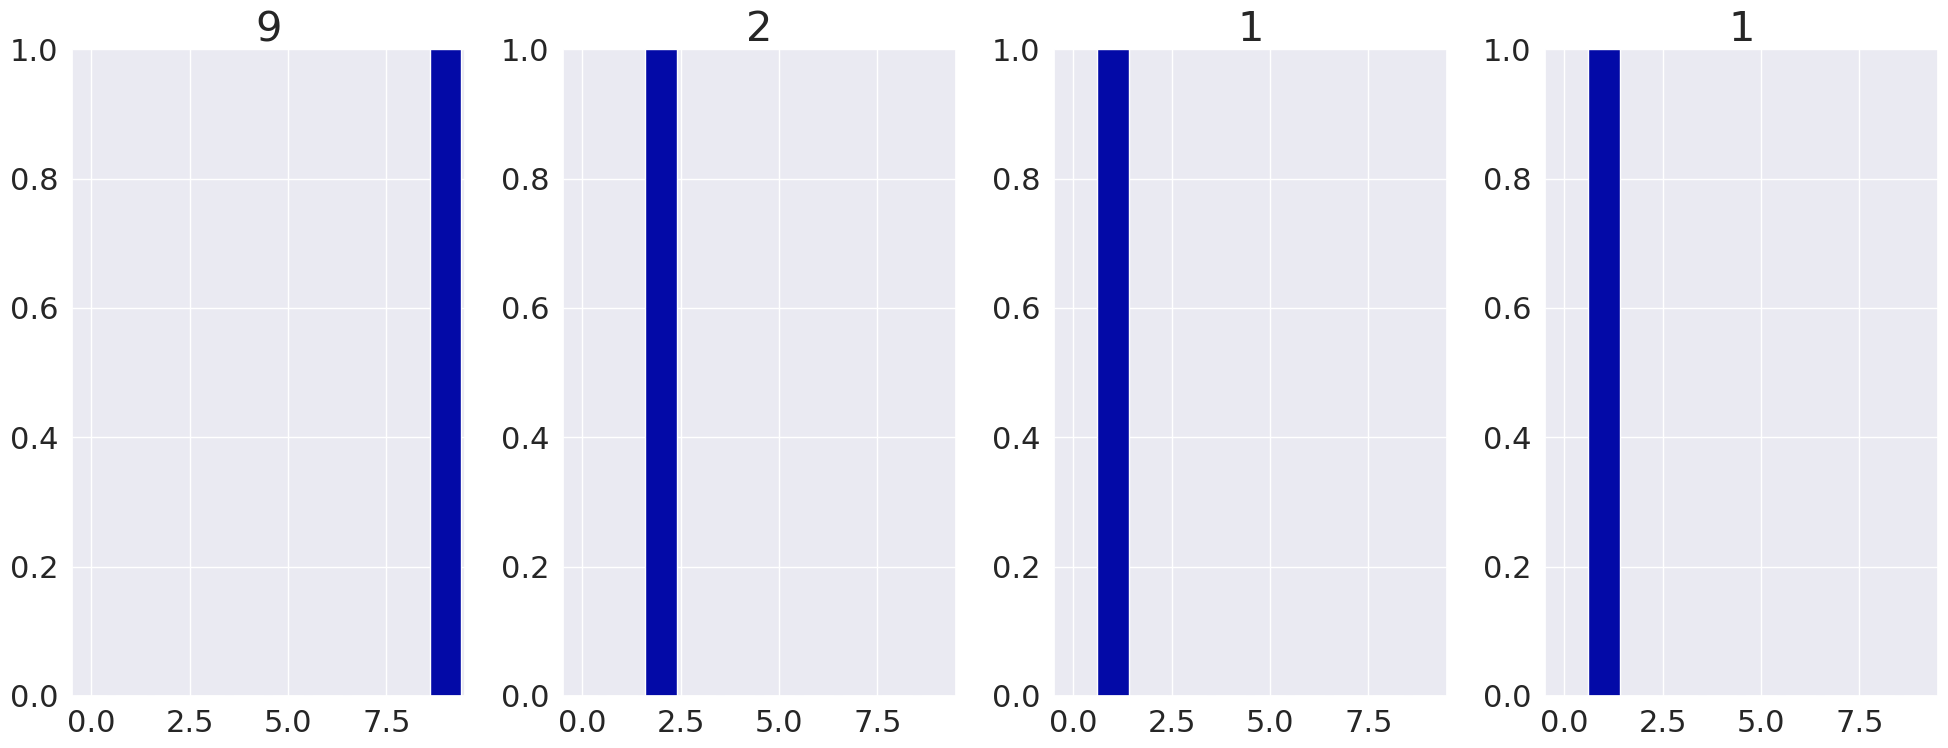

In [25]:
plt.figure(figsize=(20,8))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.bar(range(number_of_classes), probabilities[i], color="#030aa7", align='center')
    plt.xlim(-0.5, 9.5)
    plt.ylim(0, 1)
    plt.title(predictions[i],fontsize=30)
plt.tight_layout()
sauvegarderImage('Probabilités pour les 4 premiers prédictions')

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Matrice de Confusion </div></b>

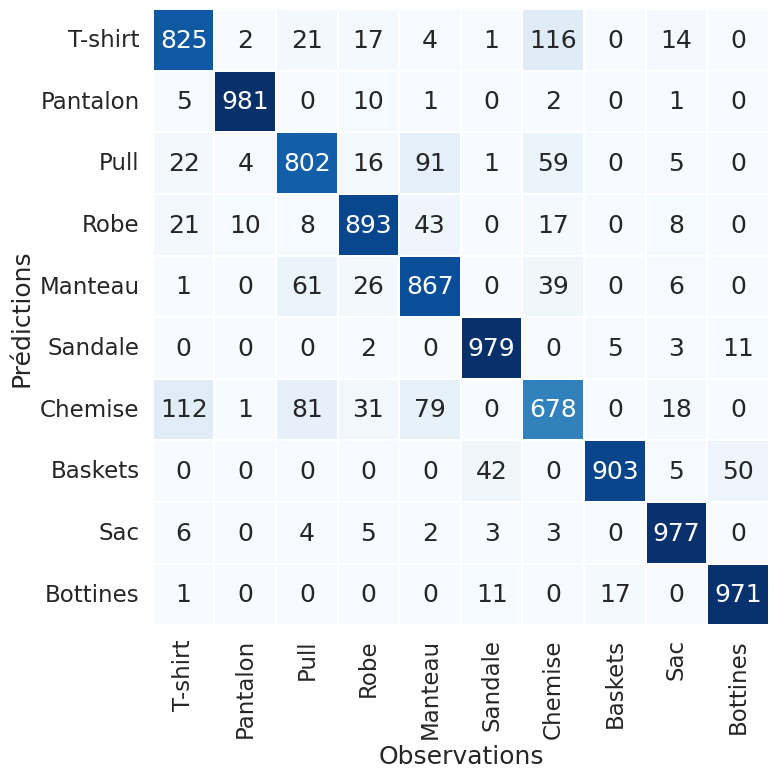

In [26]:
afficheMatriceConfusion(observations=np.argmax(y_test, axis=-1),predictions=predictions,dictLabels=dictLabels)

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Résultats de l’apprentissage</div></b>

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
Area under the ROC curve : 0.9906	--	Exécution  :10.61s


,Classe,aucROC,avgPrecRec,f1,f2,f05,accuracy,precision,sensibilite,vrais_positifs,vrais_negatifs,faux_positifs,faux_negatifs,total_positifs,essai
0,global,0.990554,0.952908,0.886789,0.887150,0.886810,0.8876,0.887038,0.8876,8876,88876,1124,1124,10000,initial
1,T-shirt,0.985939,0.903528,0.827898,0.826157,0.829646,0.9657,0.830816,0.8250,825,8832,168,175,1000,initial
2,Pantalon,0.999384,0.996759,0.981982,0.981393,0.982572,0.9964,0.982966,0.9810,981,8983,17,19,1000,initial
3,Pull,0.980449,0.879922,0.811330,0.805706,0.817033,0.9627,0.820880,0.8020,802,8825,175,198,1000,initial
4,Robe,0.993636,0.955899,0.893000,0.893000,0.893000,0.9786,0.893000,0.8930,893,8893,107,107,1000,initial
5,Manteau,0.986173,0.897675,0.830858,0.852172,0.810583,0.9647,0.797608,0.8670,867,8780,220,133,1000,initial
6,Sandale,0.999027,0.989926,0.961217,0.971809,0.950855,0.9921,0.944069,0.9790,979,8942,58,21,1000,initial
7,Chemise,0.966289,0.791995,0.708464,0.689866,0.728093,0.9442,0.741794,0.6780,678,8764,236,322,1000,initial
8,Baskets,0.998679,0.989883,0.938182,0.916751,0.960638,0.9881,0.976216,0.9030,903,8978,22,97,1000,initial
9,Sac,0.998211,0.988999,0.959254,0.969823,0.948912,0.9917,0.942141,0.9770,977,8940,60,23,1000,initial


<Figure size 1800x1800 with 0 Axes>

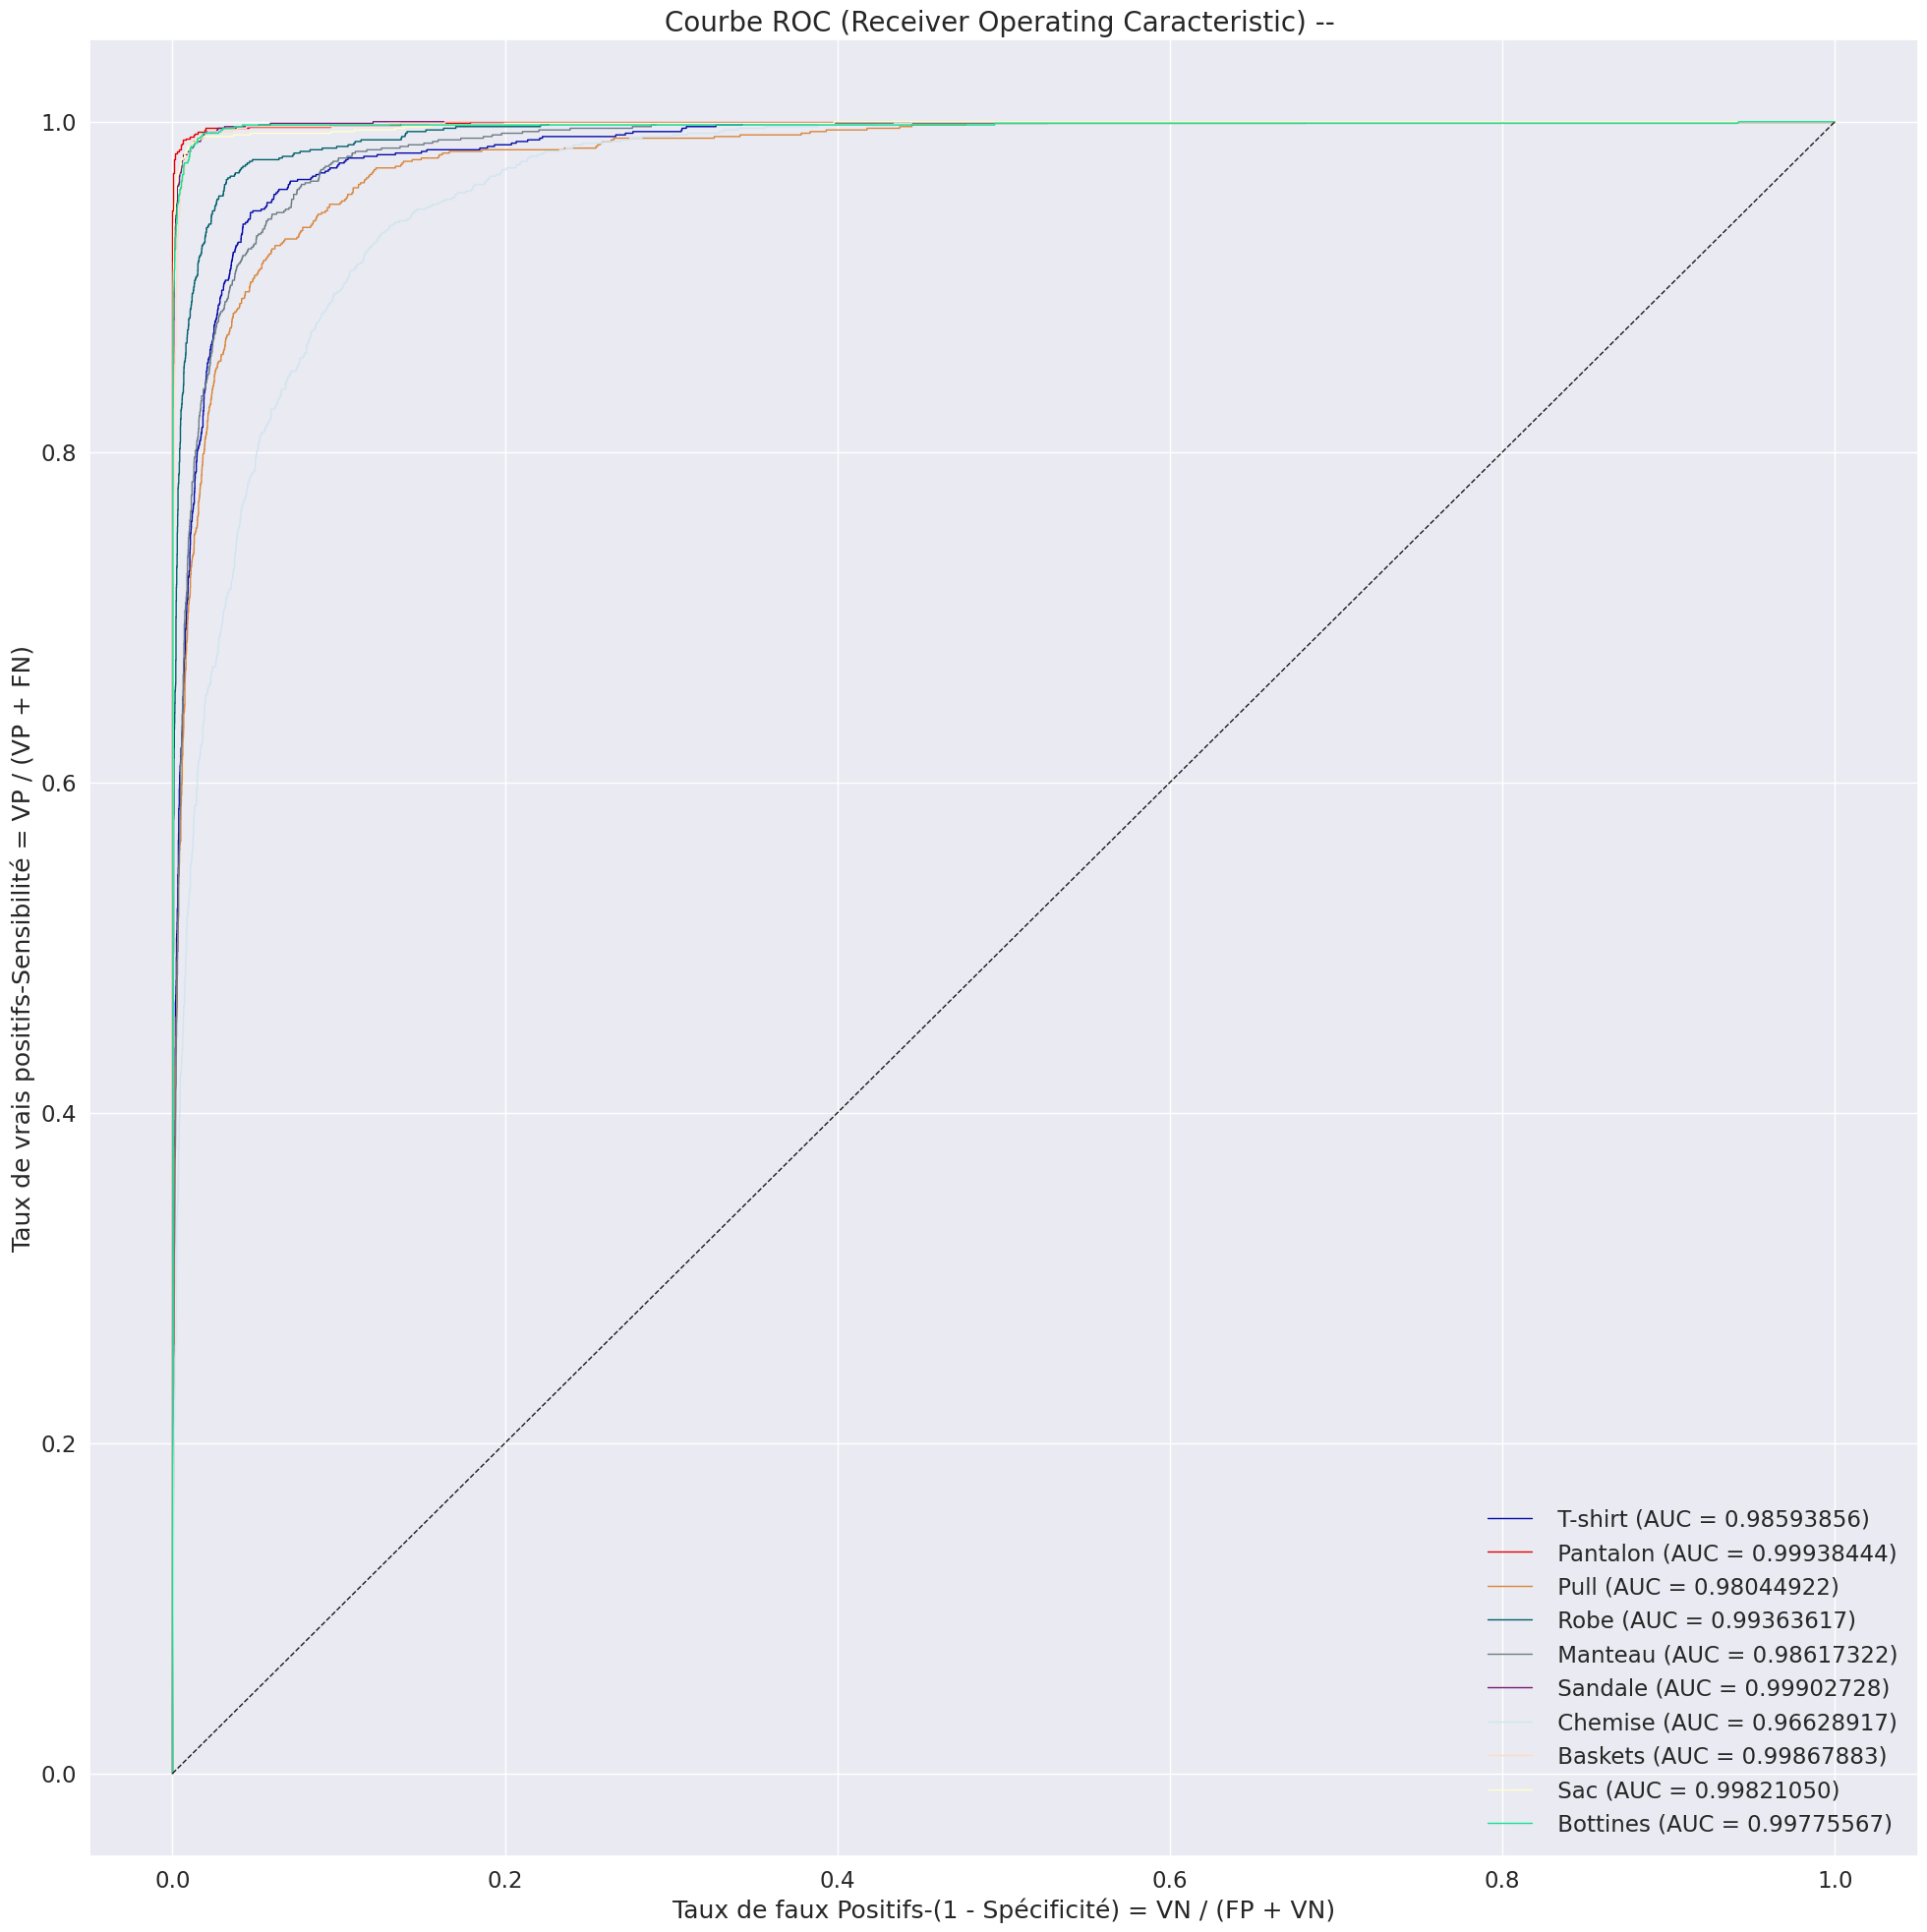

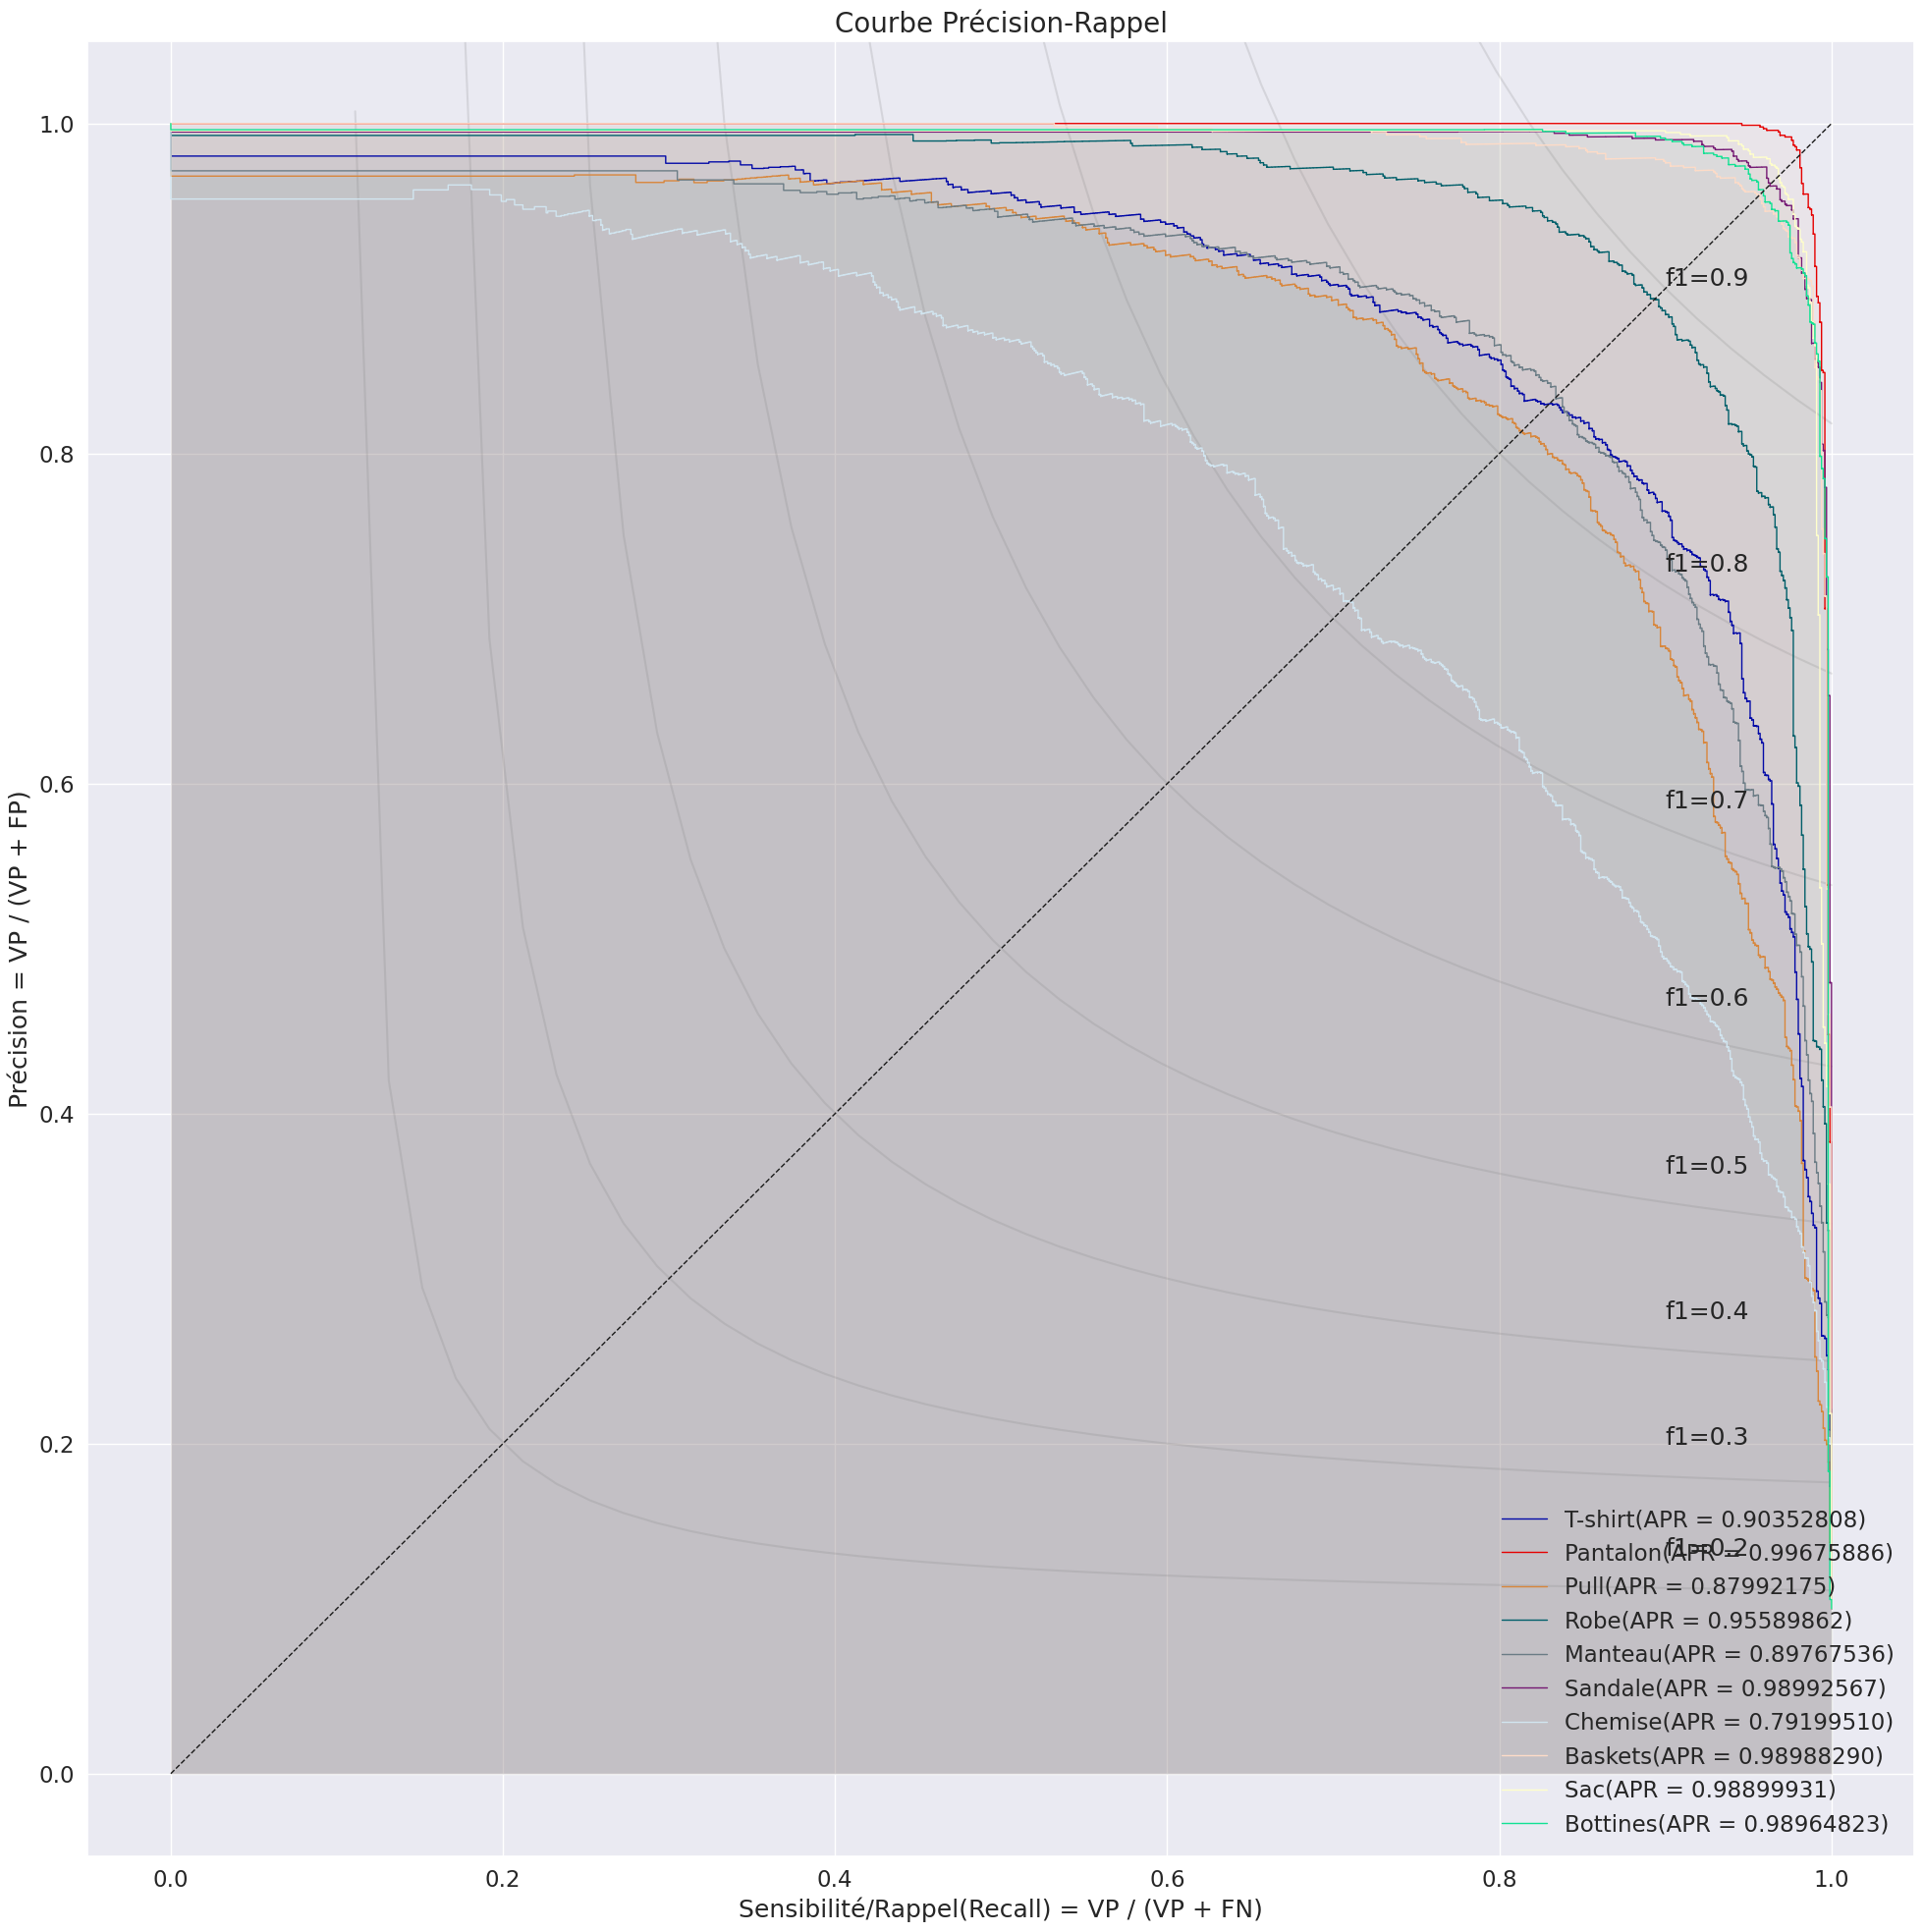

In [27]:
resultats = executeApprentissageChoixClassifieurs(
                                                  model,
                                                  X_test=X_test.reshape((X_test.shape[0], number_of_pixels)),
                                                  y_test=np.argmax(y_test, axis=-1),
                                                  label_dict=dictLabels,
                                                  couleurs=palette[2:],
                                                  nom_essai = 'initial'
                                                 )
resultats